## Creating the data

In [209]:
import numpy as np
import random

In [210]:
data_x = []
for i in range(0,500):
    sublist = [1]
    for j in range(0, 9):
        sublist.append(random.uniform(0, 1))
    data_x.append(sublist)

In [211]:
data_x = np.array(data_x)

In [212]:
weight_data = [random.uniform(0, 1) for i in range(10)]
y = np.dot(data_x, weight_data)

In [213]:
noise = np.random.normal(0,1,500)
data_y = y + noise

In [214]:
data_y = np.array(data_y)

In [215]:
len(data_y)

500

## Getting regression weight result

In [216]:
import numpy as np
from sklearn.linear_model import LinearRegression

In [217]:
model = LinearRegression(fit_intercept = False)

In [218]:
model.fit(data_x, data_y)

LinearRegression(fit_intercept=False)

In [219]:
r_sq = model.score(data_x, data_y)
print(f"coefficient of determination: {r_sq}")

coefficient of determination: 0.14481021813304673


In [220]:
print(f"slope: {model.coef_}")

slope: [ 0.82696695  0.34739373  0.44355646  0.18652648  0.71417529 -0.02595716
  0.63039927  0.48509244  0.2232071   0.70110821]


In [221]:
regression_weight = model.coef_

In [222]:
print(f"intercept: {model.intercept_}")

intercept: 0.0


In [223]:
cost(regression_weight)

48.2072089268438

## Starting our FedAvg

In [224]:
import numpy as np
import random
import matplotlib as mp
import numdifftools as nd
import math
import matplotlib.pyplot as plt
import statistics
from tqdm import tqdm as tq
import time
from numpy.linalg import norm

In [225]:
q_n_t = [random.uniform(0, 1) for i in range(10)]

In [226]:
def cost(weight):
    summation = 0
    for i in range(1,500):
        summation = summation + (data_y[i] - np.dot(data_x[i,:],weight))**2
    return 1/10*summation

In [227]:
from scipy.stats import bernoulli
def get_probability_functions():
    lst = []
    for i in range(0, 10):
        tmp = []
        for j in range(0,20):   
            tmp.append(bernoulli.rvs(size=100,p=q_n_t[i]))
        lst.append(tmp)
    return lst

In [228]:
lst = get_probability_functions()

In [229]:
def complete_gradients(weight):
    gradient = [0 for i in range(0,10)]
    for i in range(0,500):
        gradient = gradient - (2*(np.dot((data_y[i] -  np.dot(data_x[i,:], weight)),data_x[i,:])))
    return 1/10*gradient

In [230]:
def agent_complete_gradient(weight,device):
    gradient = [0 for i in range(0,10)]
    index = 50*device
    for i in range(0,50):
        gradient = gradient - (2*(np.dot((data_y[i+index] -  np.dot(data_x[i+index,:], weight)),data_x[i+index,:])))
    return 1/50*gradient

In [231]:
def agent_gradient(weight,device,random):
    index = 50*(device) + random
    gradient = -2*(data_y[index] -  np.dot(data_x[index], weight)) * data_x[index]
    return gradient

## Original FedAvg

100%|███████████████████████████████████████████| 20/20 [01:09<00:00,  3.48s/it]


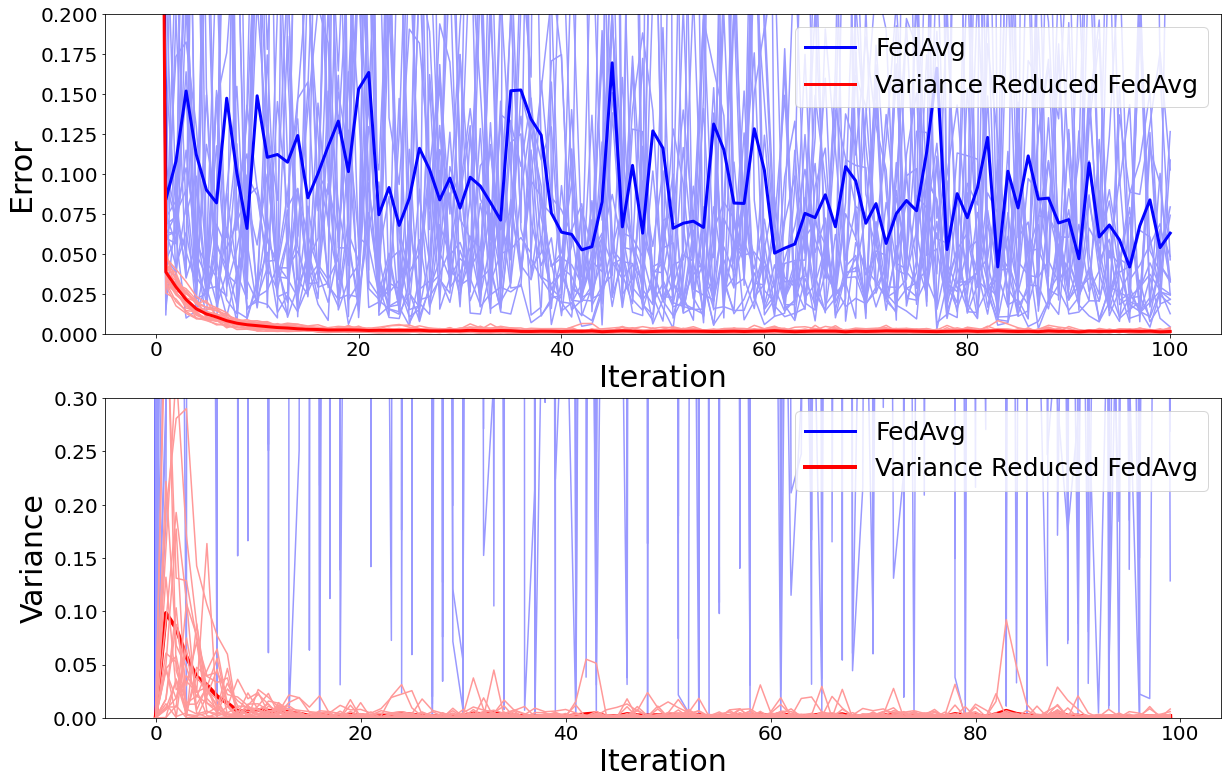

In [239]:
# Below is the original FedAvg

import random
x_x = []
y_y = []

res1 = []
res1_gradient = []
res1_d1 = []

weight = [0.5 for i in range(0,10)]

res1_variance_cost = [[cost(weight)] for i in range(0,20)]
res1_gradient = []

fig = plt.figure(figsize=(20,20))

CEP_weight_FedAvg = []
CEP_cost_FedAvg = []

for j in tq(range(0,20)):
    
    weight = [0.5 for i in range(0,10)]
    y = [1 for i in range(0,10)]
    tmp = [0 for i in range(0,10)]
    result_weight = []
    result_cost = [(norm(cost(weight)) - cost(regression_weight))/cost(regression_weight)]
    result_cost_var = [cost(weight)]
    result_gradient = [norm(complete_gradients(weight))]
    
    for iteration in range(0,100):
        for device in range(0,10):
            y[device] = weight
            tmp[device] = y[device]
            for i in range(0,50):
                import random
                random = random.randrange(0, 50)
                y[device] = y[device] - 1/math.sqrt(iteration+100) * agent_gradient(y[device],device,random)
                
        g_update = 0
        for device in range(0, 10):
            g_update += (lst[device][j][iteration]/q_n_t[device])*(y[device] - tmp[device])

        weight = weight + 1/10*g_update

        

        result_cost.append(cost(weight))

        result_cost_var.append(cost(weight))
        res1_variance_cost[j].append(cost(weight)) 

        if iteration == 99:
            CEP_weight_FedAvg.append(norm(weight))
            CEP_cost_FedAvg.append(cost(weight))
        
    res1_gradient.append(result_gradient)
    res1.append(abs((result_cost - cost(regression_weight))/cost(regression_weight)))
    res1_d1.append(result_cost_var)
    
    plt.subplot(3,1,1)
    plt.plot(abs(result_cost - cost(regression_weight))/cost(regression_weight), c=lighten_color('b',0.4))
    plt.ylim(0,0.2)
    
d1 = np.mean(res1, axis=0)
d1_var = np.mean(res1_d1, axis=0)
plt.subplot(3,1,1)
plt.plot(d1,c=lighten_color('b',0.99),label="FedAvg",linewidth=3)
plt.legend(loc='upper right',fontsize=20)

# ----------------

variance = []

for iteration in range(0,100):
    summ = 0
    diff=0
    for j in range(0,20):
        diff += (res1_variance_cost[j][iteration] - d1_var[iteration])**2
    summ = diff/20
    variance.append(summ)
plt.subplot(3,1,2)
plt.plot(variance,'b',label="FedAvg",linewidth=3)
plt.legend(loc='upper right',fontsize=20)

# ----------------

res = [[]for i in range(0,20)]
plt.subplot(3,1,2)
for j in range(0,20):
    summ = 0
    for iteration in range(0,100):
        diff = 0
        diff = (res1_variance_cost[j][iteration] - d1_var[iteration])**2
        res[j].append(diff)

    plt.plot(res[j],c=lighten_color('b',0.4))
    
    
    
# Below is FedAvg+SVRG------------------------------------


import random
x_x = []
y_y = []

res2 = []
res2_d2 = []

weight = [0.5 for i in range(0,10)]

res2_variance_cost = [[cost(weight)] for i in range(0,20)]
res2_gradient = []

CEP_weight_SVRG = []
CEP_cost_SVRG = []

for j in tq(range(0,20)):
    
    weight = [0.5 for i in range(0,10)]
    y = [1 for i in range(0,10)]
    y_bar = [1 for i in range(0,10)]
    tmp = [0 for i in range(0,10)]
    result_weight = []
    result_cost = [(norm(cost(weight)) - cost(regression_weight))/cost(regression_weight)]
    result_cost_var = [cost(weight)]
    result_gradient = [complete_gradients(weight)]
    
    for iteration in range(0,100):
        for device in range(0,10):
            y_bar[device] = weight
            tmp[device] = y_bar[device] 
            
            for s in range(0,5):
                m = agent_complete_gradient(y_bar[device],device)
                y[device] = y_bar[device]
                
                for k in range(0,2):
                    import random
                    random = random.randrange(0, 50)
                    g = m - agent_gradient(y_bar[device],device,random) + agent_gradient(y[device],device,random)
                    y[device] = y[device] - 1/math.sqrt(100)*g

                y_bar[device] = y[device]
        g_update = 0
        for device in range(0, 10):
            g_update += (lst[device][j][iteration]/q_n_t[device])*(y[device] - tmp[device])

        weight = weight + 1/10*g_update


        result_cost.append(cost(weight))

        result_cost_var.append(cost(weight))
        res2_variance_cost[j].append(cost(weight)) 
        
        if iteration == 99:
            CEP_weight_SVRG.append(norm(weight))
            CEP_cost_SVRG.append(cost(weight))

           
    res2_gradient.append(result_gradient)
    res2.append(abs((result_cost - cost(regression_weight)) / cost(regression_weight)))
    res2_d2.append(result_cost_var)
    
    plt.xlabel('Iteration',fontsize=30)
    plt.ylabel('Error',fontsize=30)
    plt.subplot(3,1,1)
    
    plt.plot(abs(result_cost - cost(regression_weight))/cost(regression_weight), c=lighten_color('r',0.4))
    
d2 = np.mean(res2, axis=0)
d2_var = np.mean(res2_d2, axis=0)

plt.subplot(3,1,1)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(d2,c=lighten_color('r',0.99),label="Variance Reduced FedAvg",linewidth=3)
plt.legend(loc='upper right',fontsize=25)
# plt.ylim(0,0.02)


# ----------------
variance = []
for iteration in range(0,100):
    summ = 0
    diff=0
    for j in range(0,20):
        diff += (res2_variance_cost[j][iteration] - d2_var[iteration])**2
    summ = diff/20
    variance.append(summ)
plt.subplot(3,1,2)
plt.ylim(0,0.3)
plt.ylabel('Variance',fontsize=30)
plt.plot(variance,'r',label="Variance Reduced FedAvg",linewidth=4)
plt.legend(loc='upper right',fontsize=25)

# -----------------

res = [[]for i in range(0,20)]
plt.subplot(3,1,2)
plt.xlabel('Iteration',fontsize=30)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
for j in range(0,20):
    summ = 0
    for iteration in range(0,100):
        diff = 0
        diff = (res2_variance_cost[j][iteration] - d2_var[iteration])**2
        res[j].append(diff)

    plt.plot(res[j],c=lighten_color('r',0.4))



fig.savefig('Cost_Variance_Simulation.jpg')

In [865]:
cost(regression_weight)

50.07406972540221

## CEP plot For FedAvg+SVRG

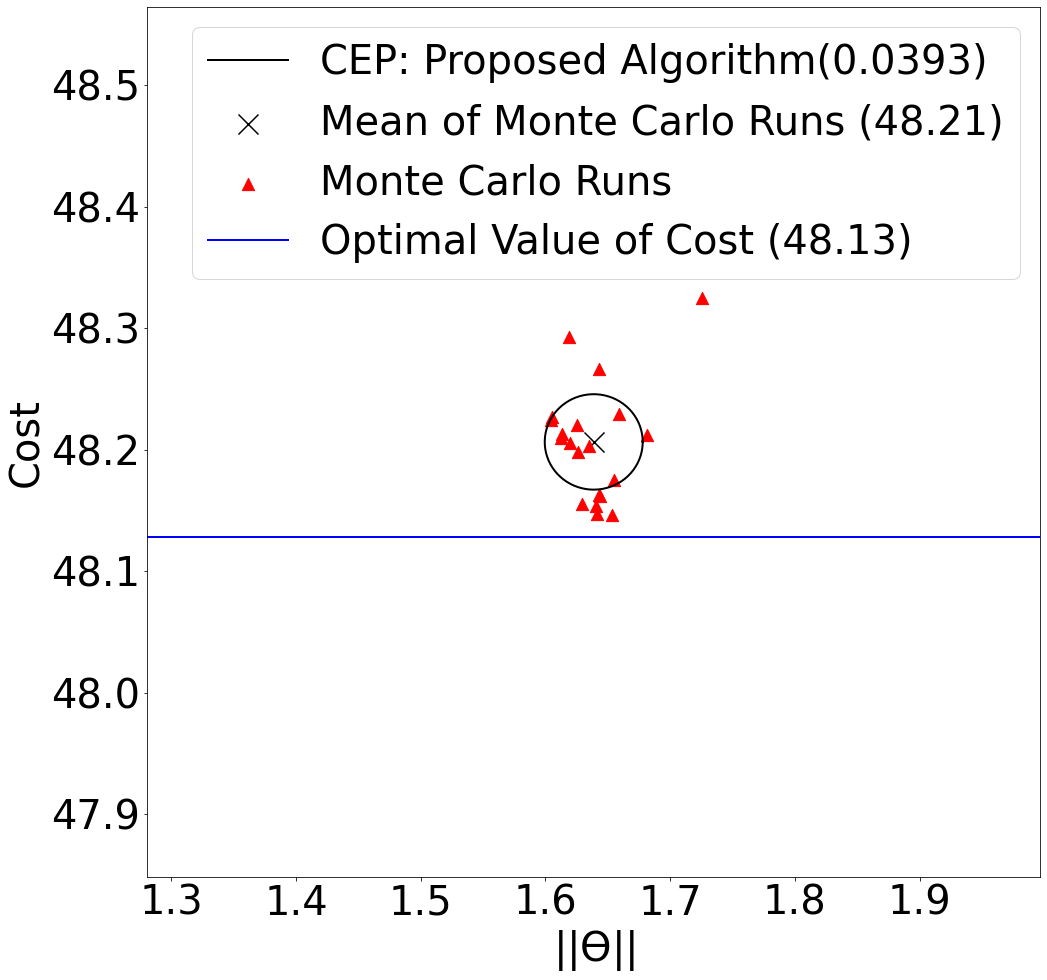

In [238]:
sum_CEP_cost = 0           
for el in CEP_cost_SVRG:
    sum_CEP_cost += el
sum_CEP_cost = sum_CEP_cost/20

sum_CEP_weight = 0           
for el in CEP_weight_SVRG:
    sum_CEP_weight += el
sum_CEP_weight = sum_CEP_weight/20

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius = getting_CEP_radius(CEP_weight_SVRG,CEP_cost_SVRG,sum_CEP_weight,sum_CEP_cost)
 
x = radius * np.cos( angle ) + sum_CEP_weight
y = radius * np.sin( angle ) + sum_CEP_cost


CEP_fig = plt.figure(figsize=(16,16))

plt.plot(x,y,c='black',label="CEP: Proposed Algorithm("+format(radius, ".4f")+")",linewidth=2)
plt.scatter(sum_CEP_weight,sum_CEP_cost,marker='x',s=400,c='black',label="Mean of Monte Carlo Runs "+ "("+format(sum_CEP_cost, ".2f")+")")
plt.scatter(CEP_weight_SVRG,CEP_cost_SVRG,marker='^',c='r',label="Monte Carlo Runs",s=150)
plt.axhline(cost(regression_weight),linewidth = 2,color = 'blue',label="Optimal Value of Cost " + "("+format(cost(regression_weight), ".2f")+")")
plt.legend(loc='upper right',fontsize=40)
# plt.axis('square')
plt.ylim(sum_CEP_cost - 1/5*radius_FedAvg,sum_CEP_cost + 1/5*radius_FedAvg)
plt.xlim(sum_CEP_weight -1/5*radius_FedAvg,sum_CEP_weight + 1/5*radius_FedAvg)
plt.xlabel('$||\u03F4||$',fontsize=40)
plt.ylabel('Cost',fontsize=40)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)


CEP_fig.savefig('CEP_FedAvg+SVRG.jpg')

 ## CEP plot For FedAvg

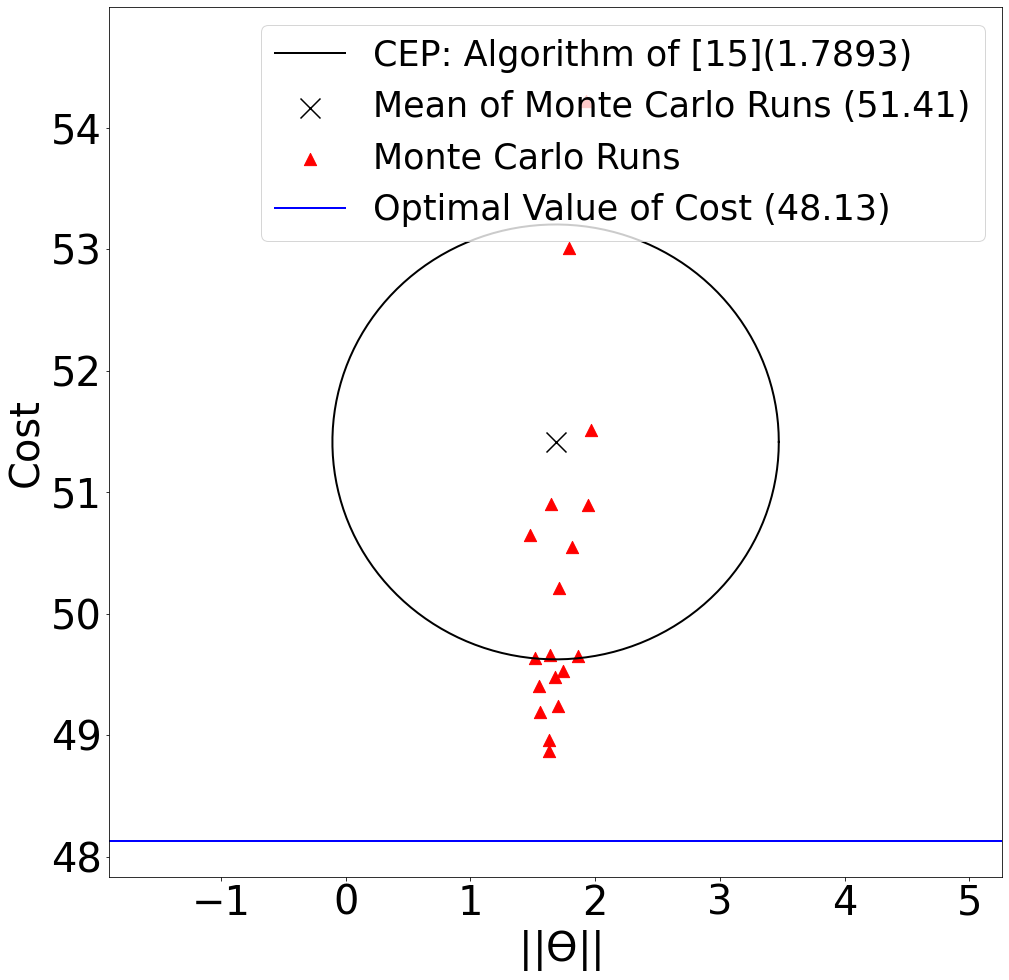

In [237]:
sum_CEP_cost = 0           
for el in CEP_cost_FedAvg:
    sum_CEP_cost += el
sum_CEP_cost = sum_CEP_cost/20

sum_CEP_weight = 0           
for el in CEP_weight_FedAvg:
    sum_CEP_weight += el
sum_CEP_weight = sum_CEP_weight/20

angle = np.linspace( 0 , 2 * np.pi , 150 ) 
radius_FedAvg = getting_CEP_radius(CEP_weight_FedAvg,CEP_cost_FedAvg,sum_CEP_weight,sum_CEP_cost)
 
x = radius_FedAvg * np.cos( angle ) + sum_CEP_weight
y = radius_FedAvg * np.sin( angle ) + sum_CEP_cost


CEP_fig = plt.figure(figsize=(16,16))

plt.plot(x,y,c='black',label="CEP: Algorithm of "+"["+"15"+"]"+ "("+format(radius_FedAvg, ".4f")+")",linewidth=2)
plt.scatter(sum_CEP_weight,sum_CEP_cost,marker='x',s=400,c='black',label="Mean of Monte Carlo Runs "+ "("+format(sum_CEP_cost, ".2f")+")")
plt.scatter(CEP_weight_FedAvg,CEP_cost_FedAvg,marker='^',s=150,c='r',label="Monte Carlo Runs")
plt.axhline(cost(regression_weight),linewidth = 2,color = 'blue',label="Optimal Value of Cost " + "("+format(cost(regression_weight), ".2f")+")")
plt.legend(loc='upper right',fontsize=35)
# plt.axis('square')
plt.ylim(sum_CEP_cost - 2*radius_FedAvg,sum_CEP_cost + 2*radius_FedAvg)
plt.xlim(sum_CEP_weight -2*radius_FedAvg,sum_CEP_weight + 2*radius_FedAvg)
plt.xlabel(' $||\u03F4||$ ',fontsize=40)
plt.ylabel('Cost',fontsize=40)
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)

CEP_fig.savefig('CEP_FedAvg.jpg')

In [233]:
import math
def getting_CEP_radius(CEP_weight,CEP_cost,CEP_sum_weight,CEP_sum_cost):
    result = []
    for i in range(0,20):
        distance = math.sqrt((CEP_weight[i] - CEP_sum_weight)**2 + (CEP_cost[i] - CEP_sum_cost)**2)
        result.append(distance)
    result = sorted(result)
    return result[9]   

In [234]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

## Plotting all the models (FedAvg+SVRG / FedAvg uniform/ FedAvg non-uniform)

100%|███████████████████████████████████████████| 20/20 [01:01<00:00,  3.06s/it]


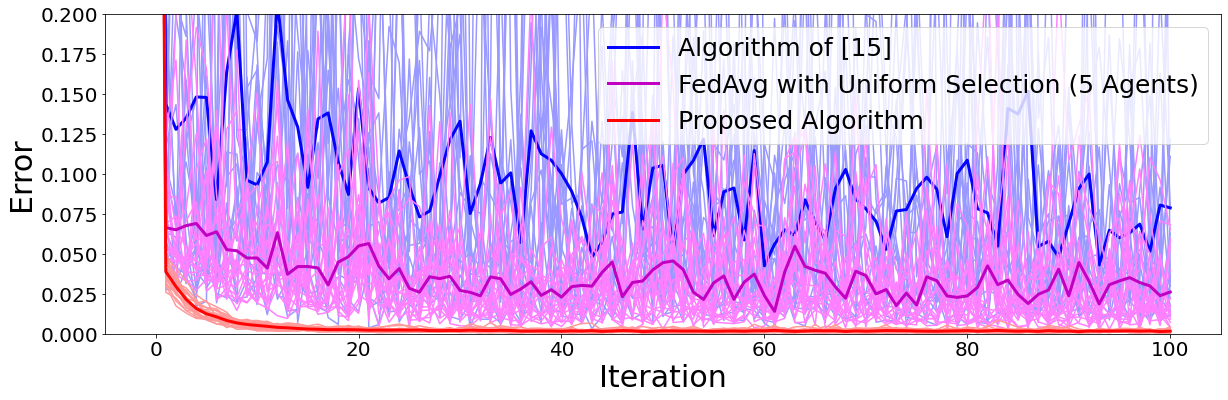

In [240]:
import random
x_x = []
y_y = []

res1 = []
res1_gradient = []
res1_d1 = []

weight = [0.5 for i in range(0,10)]

res1_variance_cost = [[cost(weight)] for i in range(0,20)]
res1_gradient = []

fig2 = plt.figure(figsize=(20,20))

CEP_weight_FedAvg = []
CEP_cost_FedAvg = []

for j in tq(range(0,20)):
    
    weight = [0.5 for i in range(0,10)]
    y = [1 for i in range(0,10)]
    tmp = [0 for i in range(0,10)]
    result_weight = []
    result_cost = [(norm(cost(weight)) - cost(regression_weight))/cost(regression_weight)]
    result_cost_var = [cost(weight)]
    result_gradient = [norm(complete_gradients(weight))]
    
    for iteration in range(0,100):
        for device in range(0,10):
            y[device] = weight
            tmp[device] = y[device]
            for i in range(0,10):
                import random
                random = random.randrange(0, 50)
                y[device] = y[device] - 1/math.sqrt(iteration+100) * agent_gradient(y[device],device,random)
                
        g_update = 0
        for device in range(0, 10):
            g_update += (lst[device][j][iteration]/q_n_t[device])*(y[device] - tmp[device])

        weight = weight + 1/10*g_update

        

        result_cost.append(cost(weight))

        result_cost_var.append(cost(weight))
        res1_variance_cost[j].append(cost(weight)) 

        if iteration == 99:
            CEP_weight_FedAvg.append(norm(weight))
            CEP_cost_FedAvg.append(cost(weight))
        
    res1_gradient.append(result_gradient)
    res1.append(abs((result_cost - cost(regression_weight))/cost(regression_weight)))
    res1_d1.append(result_cost_var)
    
    plt.subplot(3,1,1)
    plt.plot(abs(result_cost - cost(regression_weight))/cost(regression_weight), c=lighten_color('b',0.4))
    plt.ylim(0,0.2)
    
d1 = np.mean(res1, axis=0)
d1_var = np.mean(res1_d1, axis=0)
plt.subplot(3,1,1)
plt.plot(d1,c=lighten_color('b',0.99),label="Algorithm of "+"["+"15"+"]",linewidth=3)
plt.legend(loc='upper right',fontsize=20)



# -------------------Below is FedAvg with uniform agent sampling 5 agents




import random
x_x = []
y_y = []

res1 = []
# res1_gradient = []
# res1_d1 = []

weight = [0.5 for i in range(0,10)]

# res1_variance_cost = [[cost(weight)] for i in range(0,20)]
# res1_gradient = []

# fig = plt.figure(figsize=(20,20))

# CEP_weight_FedAvg = []
# CEP_cost_FedAvg = []

for j in tq(range(0,20)):
    
    weight = [0.5 for i in range(0,10)]
    y = [1 for i in range(0,10)]
    tmp = [0 for i in range(0,10)]
#     result_weight = []
    result_cost = [(norm(cost(weight)) - cost(regression_weight))/cost(regression_weight)]
#     result_cost_var = [cost(weight)]
#     result_gradient = [norm(complete_gradients(weight))]
    
    for iteration in range(0,100):
        for device in range(0,10):
            y[device] = weight
            tmp[device] = y[device]
            for i in range(0,10):
                import random
                random = random.randrange(0, 50)
                y[device] = y[device] - 1/math.sqrt(iteration+100) * agent_gradient_FedAvg(y[device],device,random)
                
        g_update = 0
        
        import random
        lst_random_agents = random.sample(range(10), 5)
        
        for device in lst_random_agents:
            g_update += 1/10*(y[device] - tmp[device])

        weight = weight + g_update

        

        result_cost.append(cost(weight))

        result_cost_var.append(cost(weight))
        res1_variance_cost[j].append(cost(weight)) 

        if iteration == 99:
            CEP_weight_FedAvg.append(norm(weight))
            CEP_cost_FedAvg.append(cost(weight))
        
    res1_gradient.append(result_gradient)
    res1.append(abs((result_cost - cost(regression_weight))/cost(regression_weight)))
    res1_d1.append(result_cost_var)
    
    plt.subplot(3,1,1)
    plt.plot(abs(result_cost - cost(regression_weight))/cost(regression_weight), c=lighten_color('m',0.4))
    plt.ylim(0,0.2)
    
d1 = np.mean(res1, axis=0)
# d1_var = np.mean(res1_d1, axis=0)
plt.subplot(3,1,1)
plt.plot(d1,c=lighten_color('m',0.99),label="FedAvg with Uniform Selection (5 Agents)",linewidth=3)
plt.legend(loc='upper right',fontsize=20)



# -------------FedAvg+SVRG is below

import random
x_x = []
y_y = []

res2 = []
res2_d2 = []

weight = [0.5 for i in range(0,10)]

res2_variance_cost = [[cost(weight)] for i in range(0,20)]
res2_gradient = []

CEP_weight_SVRG = []
CEP_cost_SVRG = []

for j in tq(range(0,20)):
    
    weight = [0.5 for i in range(0,10)]
    y = [1 for i in range(0,10)]
    y_bar = [1 for i in range(0,10)]
    tmp = [0 for i in range(0,10)]
    result_weight = []
    result_cost = [(norm(cost(weight)) - cost(regression_weight))/cost(regression_weight)]
    result_cost_var = [cost(weight)]
    result_gradient = [complete_gradients(weight)]
    
    for iteration in range(0,100):
        for device in range(0,10):
            y_bar[device] = weight
            tmp[device] = y_bar[device] 
            
            for s in range(0,5):
                m = agent_complete_gradient(y_bar[device],device)
                y[device] = y_bar[device]
                
                for k in range(0,2):
                    import random
                    random = random.randrange(0, 50)
                    g = m - agent_gradient(y_bar[device],device,random) + agent_gradient(y[device],device,random)
                    y[device] = y[device] - 1/math.sqrt(100)*g

                y_bar[device] = y[device]
        g_update = 0
        for device in range(0, 10):
            g_update += (lst[device][j][iteration]/q_n_t[device])*(y[device] - tmp[device])

        weight = weight + 1/10*g_update


        result_cost.append(cost(weight))

        result_cost_var.append(cost(weight))
        res2_variance_cost[j].append(cost(weight)) 
        
        if iteration == 99:
            CEP_weight_SVRG.append(norm(weight))
            CEP_cost_SVRG.append(cost(weight))

           
    res2_gradient.append(result_gradient)
    res2.append(abs((result_cost - cost(regression_weight)) / cost(regression_weight)))
    res2_d2.append(result_cost_var)
    
    plt.xlabel('Iteration',fontsize=30)
    plt.ylabel('Error',fontsize=30)
    plt.subplot(3,1,1)
    
    plt.plot(abs(result_cost - cost(regression_weight))/cost(regression_weight), c=lighten_color('r',0.4))
    
d2 = np.mean(res2, axis=0)
d2_var = np.mean(res2_d2, axis=0)

plt.subplot(3,1,1)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(d2,c=lighten_color('r',0.99),label="Proposed Algorithm",linewidth=3)
plt.legend(loc='upper right',fontsize=25)


fig2.savefig('Cost_Simulation_all_3_models.jpg')

In [232]:
def agent_gradient_FedAvg(weight,device,random):
    index = 50*(device) + random
    gradient = -2*(data_y[index] -  np.dot(data_x[index], weight)) * data_x[index]
    return gradient